# Data-X
## Tutorial on Regularization, Ridge, and Lasso Regression 
Reference:  
* AARSHAY JAIN - A Complete Tutorial on Ridge and Lasso Regression in Python
* https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/

# Ridge and Lasso Regression

Ridge and Lasso regression are powerful techniques generally used for creating more sparse models in presence of a ‘large’ number of features. Here ‘large’ can typically mean either of two things:

- Large enough to enhance the tendency of a model to overfit (as low as 10 variables might cause overfitting)
- Large enough to cause computational challenges. With modern systems, this situation might arise in case of millions or billions of features

Though Ridge and Lasso might appear to work towards a common goal, the inherent properties and practical use cases differ substantially. If you’ve heard of them before, you must know that they work by penalizing the magnitude of coefficients of features along with minimizing the error between predicted and actual observations. These are called ‘regularization’ techniques. The key difference is in how they assign penalty to the coefficients:

* **Ridge Regression**
    - L2-regularization 
    - Loss = RSS + $\alpha\|\beta\|^2_2$
* **Lasso Regression**
    - L1-regularization
    - Loss = RSS + $\alpha\|\beta\|_1$
    
Recall the residual sum of squares loss 

$RSS = ||y - X \beta||^2$

In [1]:
%load_ext autoreload
%autoreload

# load packages
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

plt.rcParams['figure.figsize'] = 7, 5

import warnings
warnings.filterwarnings('ignore')

## Why penalize the magnitude of coefficients?

Consider the following simulation of a sine curve:

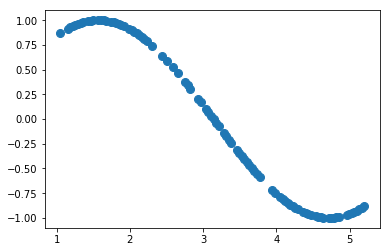

In [5]:
#Define input array with angles from 60deg to 300deg converted to radians
x_full = np.array([i*np.pi/180 for i in range(60,300,2)])

np.random.seed(10)  #Setting seed for reproducability

# ADD NOISE BELOW:
y_full = np.sin(x_full)

# split into train and test sets
x, x_test, y, y_test = train_test_split(x_full,y_full,test_size=0.25)

data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y']) # train data
data_test = pd.DataFrame(np.column_stack([x_test,y_test]),columns=['x','y']) # test data

plt.plot(data['x'],data['y'],'.',ms=16);

In [4]:
# create list w pointers to train and test DF
combine = [data, data_test]

for df in combine:
    # so that plotting makes sense
    # x values need to be sorted
    df.sort_values('x',inplace=True)

### First Thoughts: Polynomial Regression 
Features: $X^1, X^2, \dots, X^{15}$

In [38]:
# Create polynomial columns
for df in combine:

    for i in range(2,16):  #power of 1 is already there
        colname = 'x^%d'%i      #new var will be x^power
        
        # Below add x to the power as i to the dataframe.



,x,y,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9,x^10,x^11,x^12,x^13,x^14,x^15
15,1.1,0.88,1.2,1.3,1.4,1.5,1.6,1.7,1.9,2,2.2,2.4,2.6,2.8,3,3.3
9,1.1,0.9,1.2,1.4,1.6,1.7,1.9,2.2,2.4,2.7,3,3.4,3.8,4.2,4.7,5.3
16,1.4,0.98,1.9,2.7,3.8,5.3,7.4,10,14,20,28,39,55,77,1.1e+02,1.5e+02
24,1.5,1,2.4,3.6,5.6,8.5,13,20,31,48,73,1.1e+02,1.7e+02,2.6e+02,4.1e+02,6.2e+02
23,1.7,0.99,2.9,5,8.6,15,25,43,73,1.3e+02,2.1e+02,3.7e+02,6.3e+02,1.1e+03,1.8e+03,3.1e+03
19,2,0.93,3.8,7.5,15,29,56,1.1e+02,2.1e+02,4.2e+02,8.1e+02,1.6e+03,3.1e+03,6.1e+03,1.2e+04,2.3e+04
17,2.3,0.77,5.1,12,27,60,1.4e+02,3.1e+02,7e+02,1.6e+03,3.6e+03,8.2e+03,1.9e+04,4.2e+04,9.6e+04,2.2e+05
22,2.3,0.72,5.5,13,30,70,1.6e+02,3.8e+02,9e+02,2.1e+03,4.9e+03,1.1e+04,2.7e+04,6.3e+04,1.5e+05,3.4e+05
26,2.4,0.69,5.6,13,32,75,1.8e+02,4.2e+02,1e+03,2.4e+03,5.7e+03,1.3e+04,3.2e+04,7.6e+04,1.8e+05,4.3e+05
25,2.4,0.67,5.8,14,34,81,2e+02,4.7e+02,1.1e+03,2.7e+03,6.6e+03,1.6e+04,3.8e+04,9.2e+04,2.2e+05,5.3e+05


Let's consider building 15 models as follows:
* Model 1: Features - $X^1$
* Model 2: Features - $X, X^2$
* $\dots$
* Model 15: Features - $X, X^2, X^{15}$

In [14]:
class ModelEval:
    def __init__(self, data, data_test, models_to_plot, model_name='Model', alphas = None):
        self.data = data
        self.data_test = data_test
        self.models_to_plot = models_to_plot
        self.model_name = model_name
        
        #Initialize a dataframe to store the results:
        col = ['rss_train','rss_test','intercept'] + ['coef_x^%d'%i for i in range(1,16)]
        if alphas:
            ind = ['alpha_%.2g'%alphas[i] for i in range(len(alphas))]
        else:
            ind = ['model_pow_%d'%i for i in range(1,16)]
        
        self.results = pd.DataFrame(index=ind, columns=col)
        self.results.index.name = model_name
        
        self.count = 0
        
    def mod_name(self,name):
        self.model_name = name
        self.results.index.name = name
            
    def fit_predict_plot(self,model, power=15, alpha = None):
        
        predictors=['x']
        if power>=2:
            predictors.extend(['x^%d'%i for i in range(2,power+1)])
        
        model.fit(self.data[predictors], self.data['y'])
        ypred = model.predict(self.data[predictors])
        
        rss = sum((ypred-data['y'])**2)
        self.metrics = [rss]
    
        y_pred_test = model.predict(self.data_test[predictors])
        rss_test = sum((y_pred_test-self.data_test['y'])**2)
        self.metrics.extend([rss_test])
    
        self.metrics.extend([model.intercept_])
        self.metrics.extend(model.coef_)

        
        self.results.iloc[self.count,0:power+3] = self.metrics
        self.count = self.count+1
        
        if power in self.models_to_plot or alpha in self.models_to_plot:
            if alpha:
                plt.plot(self.models_to_plot[alpha])
                plt.title('Plot for model {} alpha: {}'.format(self.model_name,str(alpha)))
            else:
                plt.plot(self.models_to_plot[power])
                plt.title('Plot for model {} power: {}'.format(self.model_name,str(power)))
                
            plt.tight_layout()
            plt.plot(self.data['x'],ypred)
            plt.plot(self.data['x'],self.data['y'],'.',ms=10)
            plt.ylim([-1.5,1.5])
            plt.xlim([1,5.5])
            plt.show()

In [15]:
models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

modeval = ModelEval(data, data_test, models_to_plot)

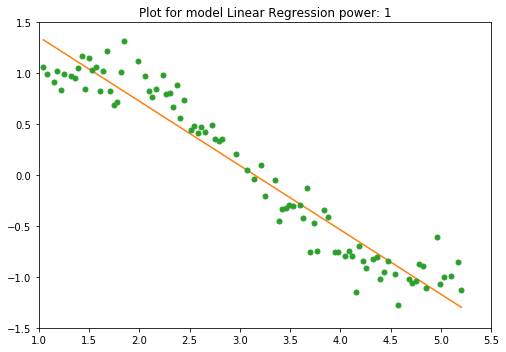

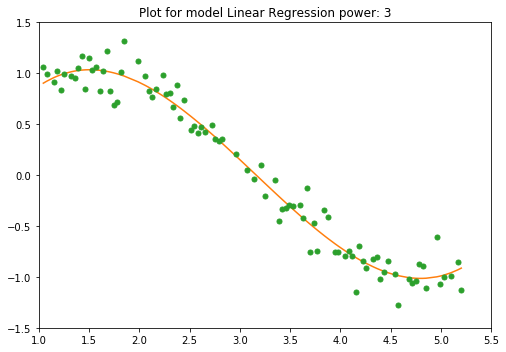

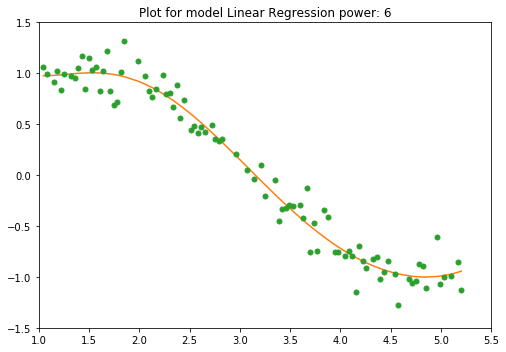

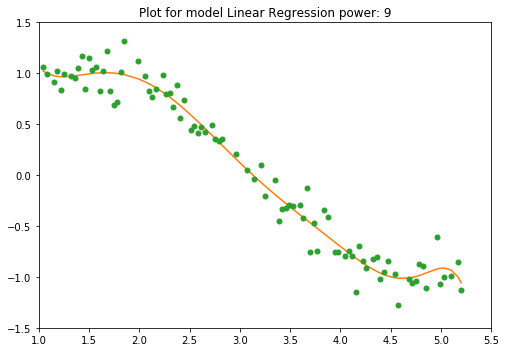

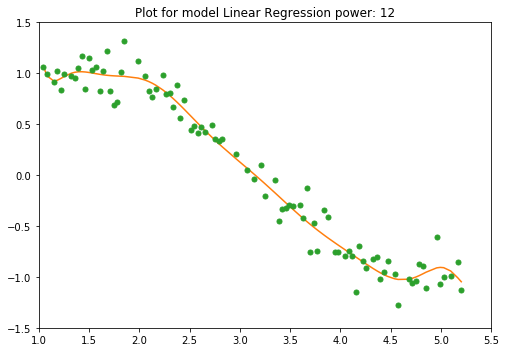

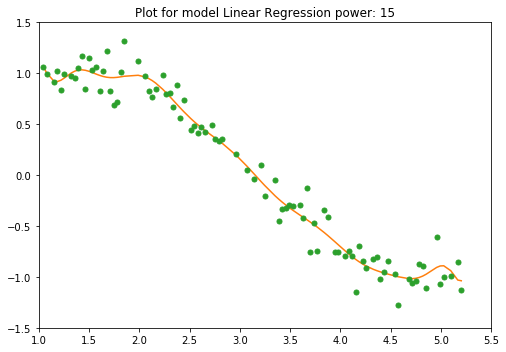

In [16]:
#Iterate through all powers and assimilate results
from sklearn.linear_model import LinearRegression
modeval.mod_name('Linear Regression')

#Below do linear regression with normalization

for i in range(1,16):
    modeval.fit_predict_plot(model=mod, power=i)    

This clearly aligns with our initial understanding. As the model complexity increases, the models tends to fit even smaller deviations in the training data set. We start to fit the gaussian noise in the data (patterns that is not there)

However, as we add more features, we expect ourselves to overfit!

## Let's look at the linear regression coefficient values:

Note RSS is the linear regression loss. So low RSS corresponds to a model with better fit.

In [17]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
modeval.results

,rss_train,rss_test,intercept,coef_x^1,coef_x^2,coef_x^3,coef_x^4,coef_x^5,coef_x^6,coef_x^7,coef_x^8,coef_x^9,coef_x^10,coef_x^11,coef_x^12,coef_x^13,coef_x^14,coef_x^15
Linear Regression,,,,,,,,,,,,,,,,,,
model_pow_1,4.2,2.3,2,-0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,4.1,2.3,1.9,-0.56,-0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,1.8,0.79,-0.65,2.5,-1.1,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,1.8,0.78,-0.59,2.4,-1,0.1,0.0011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,1.7,0.79,1.3,-1.5,1.9,-0.96,0.18,-0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,1.7,0.8,2.9,-5.6,6.1,-3,0.72,-0.084,0.0039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,1.7,0.8,20,-56,67,-41,14,-2.9,0.32,-0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,1.7,0.85,-6,32,-59,56,-30,9.8,-1.9,0.19,-0.0082,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,1.7,0.85,20,-68,1e+02,-93,54,-21,5.3,-0.84,0.077,-0.003,NaN,NaN,NaN,NaN,NaN,NaN


It is clearly evident that the size of coefficients increase exponentially with increase in model complexity.

What does a large coefficient signify? 

It means that we’re putting a lot of emphasis on that feature, i.e. the particular feature is a good predictor for the outcome. When it becomes too large, the algorithm starts modelling intricate relations to estimate the output and ends up overfitting to the particular training data.

## Ridge Regression

Note the ‘Ridge’ function used here. It takes ‘alpha’ as a parameter on initialization.

Now, lets analyze the result of Ridge regression for 10 different values of α ranging from 1e-15 to 20. Note that each of these 10 models will contain all the 15 variables and only the value of alpha would differ.

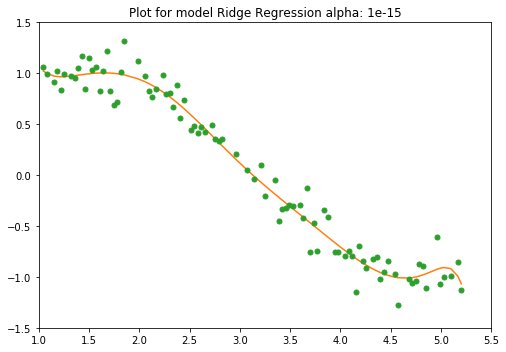

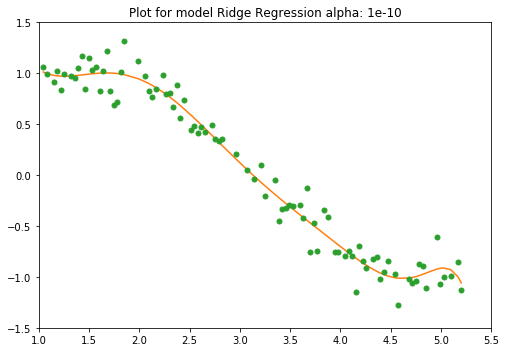

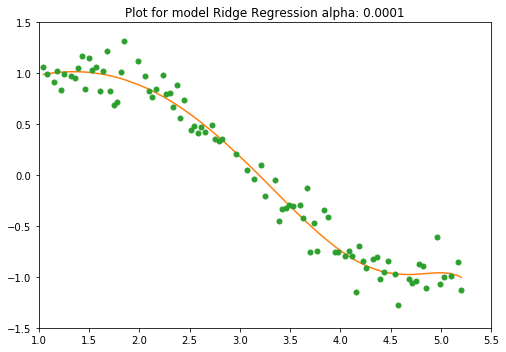

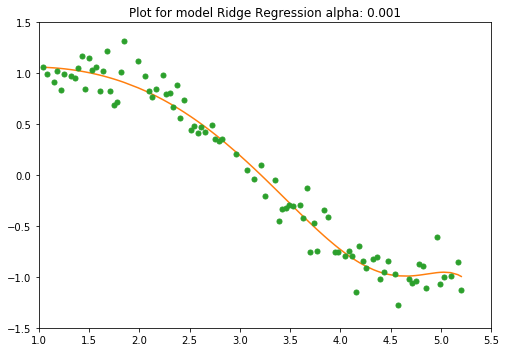

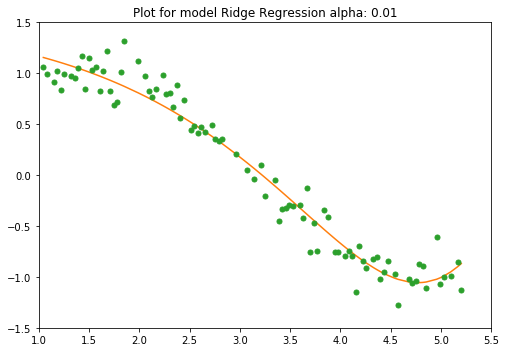

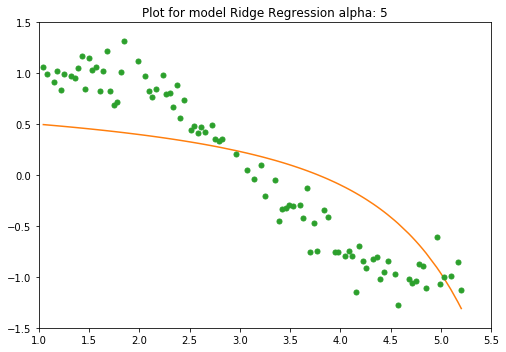

In [22]:
from sklearn.linear_model import Ridge
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
mods_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}

modeval = ModelEval(data, data_test, models_to_plot = mods_to_plot, alphas=alpha_ridge)
modeval.mod_name('Ridge Regression')

for i in range(10):
    # Create a ridge regression model below:
    
    modeval.fit_predict_plot(model=mod, alpha = mod.alpha) 

Here we can clearly observe that as the value of alpha increases, the model complexity reduces. Though higher values of alpha reduce overfitting, significantly high values can cause underfitting as well (eg. alpha = 5). Thus alpha should be chosen wisely. A widely accept technique is cross-validation, i.e. the value of alpha is iterated over a range of values and the one giving higher cross-validation score is chosen.

**USE CROSS VALIDATION**

In [20]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
modeval.results

,rss_train,rss_test,intercept,coef_x^1,coef_x^2,coef_x^3,coef_x^4,coef_x^5,coef_x^6,coef_x^7,coef_x^8,coef_x^9,coef_x^10,coef_x^11,coef_x^12,coef_x^13,coef_x^14,coef_x^15
Ridge Regression,,,,,,,,,,,,,,,,,,
alpha_1e-15,1.7,0.85,45,-1.7e+02,2.9e+02,-2.7e+02,1.5e+02,-50,8.1,0.074,-0.19,-0.0083,0.0087,-0.00026,-0.00021,2.1e-05,1e-06,-1.5e-07
alpha_1e-10,1.7,0.85,5.9,-12,10,-3.3,0.18,0.083,0.00067,-0.0022,-0.00031,1.2e-05,9.6e-06,1.1e-06,-8.2e-08,-2.6e-08,3.5e-09,-5.4e-10
alpha_1e-08,1.7,0.84,3,-4.9,3.9,-1,-0.047,0.027,0.0048,-1.5e-05,-0.00015,-3.3e-05,-2.8e-06,4.1e-07,2e-07,3.5e-08,1.3e-09,-1.5e-09
alpha_0.0001,1.8,0.79,0.54,0.65,-0.18,-0.029,-0.0016,0.0003,0.00011,2e-05,2.6e-06,2.3e-07,1.3e-11,-5e-09,-1.3e-09,-2.4e-10,-4.1e-11,-8.6e-12
alpha_0.001,1.8,0.89,0.95,0.22,-0.089,-0.018,-0.0022,-9.7e-05,3.1e-05,1.2e-05,2.7e-06,5e-07,7.9e-08,9.8e-09,6e-10,-1.7e-10,-9.1e-11,-2.9e-11
alpha_0.01,2.2,1.2,1.4,-0.13,-0.049,-0.009,-0.0012,-0.0001,2.6e-06,3.7e-06,1.1e-06,2.4e-07,4.4e-08,6.8e-09,7.9e-10,2.4e-11,-2.5e-11,-1.1e-11
alpha_1,8.1,3.5,0.98,-0.14,-0.019,-0.003,-0.00048,-7.2e-05,-1e-05,-1.4e-06,-1.6e-07,-1.3e-08,5.7e-10,6.3e-10,2.1e-10,5.5e-11,1.3e-11,2.9e-12
alpha_5,21,7.2,0.57,-0.06,-0.0087,-0.0015,-0.00025,-4.3e-05,-7.3e-06,-1.2e-06,-2e-07,-3.4e-08,-5.5e-09,-8.9e-10,-1.4e-10,-2.2e-11,-3.3e-12,-4.8e-13
alpha_10,27,9.2,0.42,-0.038,-0.0057,-0.00099,-0.00018,-3.1e-05,-5.5e-06,-9.8e-07,-1.7e-07,-3.1e-08,-5.4e-09,-9.6e-10,-1.7e-10,-3e-11,-5.3e-12,-9.4e-13


### Conclusions

We can make the following conclusions:

1. An alpha as small as 1e-15 gives us significant reduction in magnitude of coefficients. How? Compare the coefficients in the first row of this table to the last row of simple linear regression table.
2. High alpha values can lead to significant underfitting. Note the rapid increase in RSS for values of alpha greater than 1
3. Though the coefficients are **very very small, they are NOT zero**.
4. The RSS_train increases with increase in alpha, while rss_test is optimized when alpha is around 0.0001 (note edge cases not perfect)


In [40]:
# count how many of the coefficents are zero (in the full coefficient matrix)
modeval.results

# Count the number of coefficient values that are 0.

,rss_train,rss_test,intercept,coef_x^1,coef_x^2,coef_x^3,coef_x^4,coef_x^5,coef_x^6,coef_x^7,coef_x^8,coef_x^9,coef_x^10,coef_x^11,coef_x^12,coef_x^13,coef_x^14,coef_x^15
Lasso Regression,,,,,,,,,,,,,,,,,,
alpha_1e-15,1.7,0.77,-0.18,1.7,-0.61,7.9e-05,0.0077,0.00095,-7.6e-06,-2.3e-05,-4.3e-06,-2.8e-07,7.3e-08,3.2e-08,6.8e-09,8.1e-10,-5.5e-11,-7.1e-11
alpha_1e-10,1.7,0.77,-0.18,1.7,-0.61,7.9e-05,0.0077,0.00095,-7.6e-06,-2.3e-05,-4.3e-06,-2.8e-07,7.3e-08,3.2e-08,6.8e-09,8.1e-10,-5.5e-11,-7.1e-11
alpha_1e-08,1.7,0.77,-0.18,1.7,-0.61,7.5e-05,0.0076,0.00095,-6.8e-06,-2.2e-05,-4.2e-06,-2.8e-07,6.9e-08,3.2e-08,6.8e-09,8.1e-10,-4.9e-11,-7.2e-11
alpha_1e-05,1.7,0.79,0.33,0.97,-0.33,-0.0088,-0,0,0.00014,2.1e-05,0,0,0,0,-0,-0,-0,-2.1e-11
alpha_0.0001,1.9,0.98,1.1,0,-0.0084,-0.035,-0,0,0,9.8e-06,5.9e-06,0,0,0,0,-0,-0,-1.9e-11
alpha_0.001,2.5,1.4,1.3,-0.013,-0.12,-0,-0,0,0,0,0,0,0,7.1e-09,1.5e-09,0,0,0
alpha_0.01,5,2.7,1.7,-0.52,-0.006,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,0,0,0
alpha_1,59,19,0.049,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_5,59,19,0.049,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


We note that none of the coefficients are 0!

## LASSO Regression 
#### (Least Absolute Shrinkage and Selection Operator)

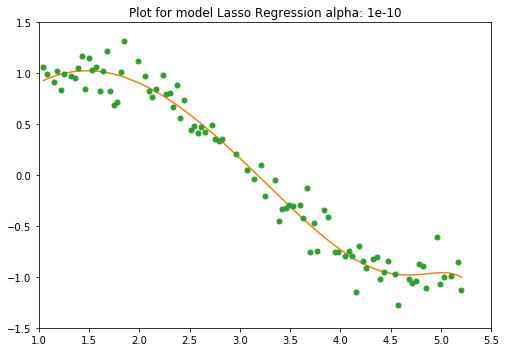

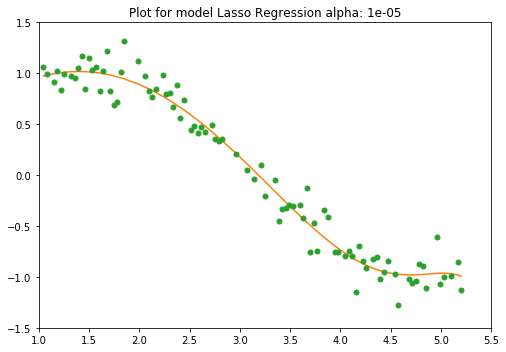

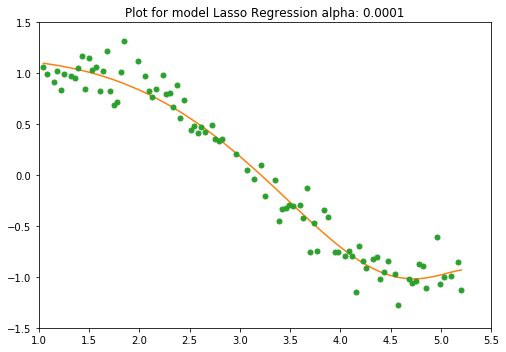

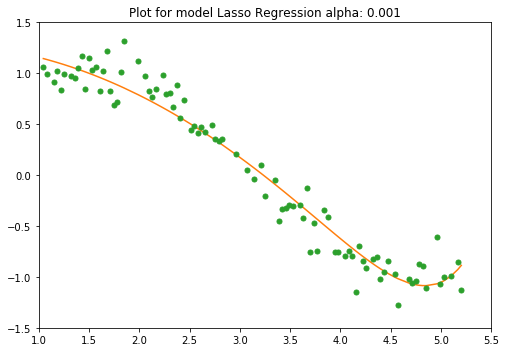

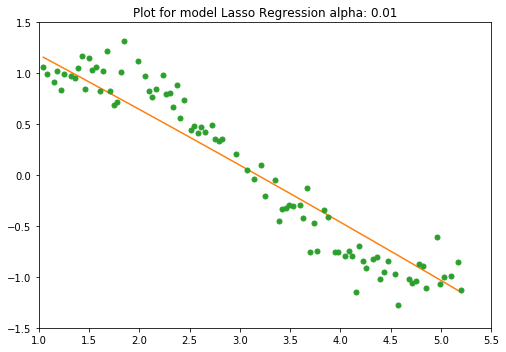

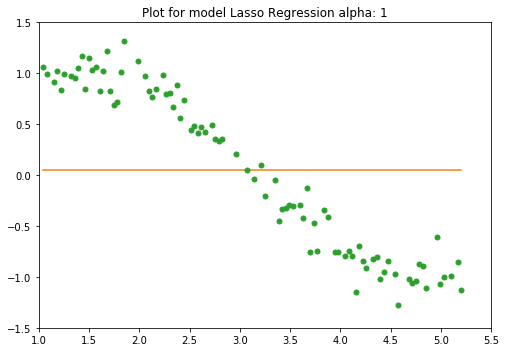

In [23]:
from sklearn.linear_model import Lasso
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]
mods_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

modeval = ModelEval(data, data_test, models_to_plot=mods_to_plot, alphas=alpha_lasso)
modeval.mod_name('Lasso Regression')

for i in range(10):
    # Create a Lasso model below:
    
    modeval.fit_predict_plot(model=mod, alpha = mod.alpha) 

In [24]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
modeval.results

,rss_train,rss_test,intercept,coef_x^1,coef_x^2,coef_x^3,coef_x^4,coef_x^5,coef_x^6,coef_x^7,coef_x^8,coef_x^9,coef_x^10,coef_x^11,coef_x^12,coef_x^13,coef_x^14,coef_x^15
Lasso Regression,,,,,,,,,,,,,,,,,,
alpha_1e-15,1.7,0.77,-0.18,1.7,-0.61,7.9e-05,0.0077,0.00095,-7.6e-06,-2.3e-05,-4.3e-06,-2.8e-07,7.3e-08,3.2e-08,6.8e-09,8.1e-10,-5.5e-11,-7.1e-11
alpha_1e-10,1.7,0.77,-0.18,1.7,-0.61,7.9e-05,0.0077,0.00095,-7.6e-06,-2.3e-05,-4.3e-06,-2.8e-07,7.3e-08,3.2e-08,6.8e-09,8.1e-10,-5.5e-11,-7.1e-11
alpha_1e-08,1.7,0.77,-0.18,1.7,-0.61,7.5e-05,0.0076,0.00095,-6.8e-06,-2.2e-05,-4.2e-06,-2.8e-07,6.9e-08,3.2e-08,6.8e-09,8.1e-10,-4.9e-11,-7.2e-11
alpha_1e-05,1.7,0.79,0.33,0.97,-0.33,-0.0088,-0,0,0.00014,2.1e-05,0,0,0,0,-0,-0,-0,-2.1e-11
alpha_0.0001,1.9,0.98,1.1,0,-0.0084,-0.035,-0,0,0,9.8e-06,5.9e-06,0,0,0,0,-0,-0,-1.9e-11
alpha_0.001,2.5,1.4,1.3,-0.013,-0.12,-0,-0,0,0,0,0,0,0,7.1e-09,1.5e-09,0,0,0
alpha_0.01,5,2.7,1.7,-0.52,-0.006,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,0,0,0
alpha_1,59,19,0.049,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_5,59,19,0.049,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


Notice that as alpha increases, many of the coefficients beceom zeroed out. We say the model has sparsity, because effectively we are only using a small number of the features.

### Conclusions:

Apart from the expected inference of higher RSS for higher alphas, we can see the following:

1. For the same values of alpha, the coefficients of lasso regression are much smaller as compared to that of ridge regression (compare row 1 of the 2 tables).
2. For the same alpha, lasso has higher RSS (poorer fit) as compared to ridge regression
3. Many of the coefficients are zero even for very small values of alpha


In [58]:
modeval.results

# Count the number of 0 coefficients for each value of alpha


,rss_train,rss_test,intercept,coef_x^1,coef_x^2,coef_x^3,coef_x^4,coef_x^5,coef_x^6,coef_x^7,coef_x^8,coef_x^9,coef_x^10,coef_x^11,coef_x^12,coef_x^13,coef_x^14,coef_x^15
Lasso Regression,,,,,,,,,,,,,,,,,,
alpha_1e-15,1.7,0.77,-0.18,1.7,-0.61,7.9e-05,0.0077,0.00095,-7.6e-06,-2.3e-05,-4.3e-06,-2.8e-07,7.3e-08,3.2e-08,6.8e-09,8.1e-10,-5.5e-11,-7.1e-11
alpha_1e-10,1.7,0.77,-0.18,1.7,-0.61,7.9e-05,0.0077,0.00095,-7.6e-06,-2.3e-05,-4.3e-06,-2.8e-07,7.3e-08,3.2e-08,6.8e-09,8.1e-10,-5.5e-11,-7.1e-11
alpha_1e-08,1.7,0.77,-0.18,1.7,-0.61,7.5e-05,0.0076,0.00095,-6.8e-06,-2.2e-05,-4.2e-06,-2.8e-07,6.9e-08,3.2e-08,6.8e-09,8.1e-10,-4.9e-11,-7.2e-11
alpha_1e-05,1.7,0.79,0.33,0.97,-0.33,-0.0088,-0,0,0.00014,2.1e-05,0,0,0,0,-0,-0,-0,-2.1e-11
alpha_0.0001,1.9,0.98,1.1,0,-0.0084,-0.035,-0,0,0,9.8e-06,5.9e-06,0,0,0,0,-0,-0,-1.9e-11
alpha_0.001,2.5,1.4,1.3,-0.013,-0.12,-0,-0,0,0,0,0,0,0,7.1e-09,1.5e-09,0,0,0
alpha_0.01,5,2.7,1.7,-0.52,-0.006,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,0,0,0
alpha_1,59,19,0.049,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_5,59,19,0.049,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


We can see that as $\alpha$ increases, the number of coefficients being set to zero increases from 0 to 15. Implicitly, Lasso conducts feature selection as well!

- Lasso works the best with sparsity 

# Why?

## Geometrical Intuition

 From the figure, one can see that the constraint region defined by the $L_1$ norm is a square rotated so that its corners lie on the axes, while the region defined by the $L_2$ norm is a circle (in general an n-sphere), which is rotationally invariant and, therefore, has no corners. As seen in the figure, a convex object that lies tangent to the boundary, such as the line shown, is likely to encounter a corner (or a higher-dimensional equivalent) of a hypercube, for which some components of $\beta$  are identically zero, while in the case of an n-sphere, the points on the boundary for which some of the components of $\beta$ are zero are not distinguished from the others.

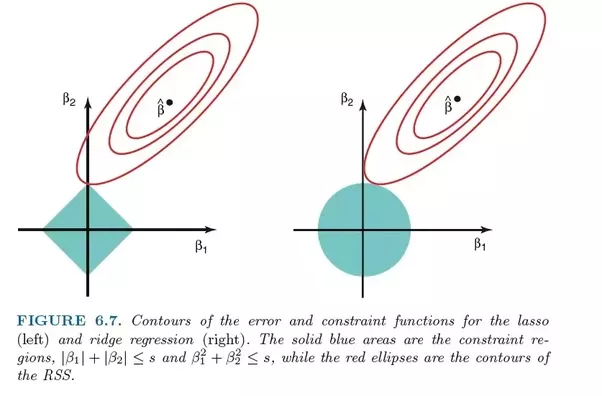


# A little more rigorously


## Let's good at gradients of the loss function!

Consider gradient of the ridge regression penalty with respect to a particular coefficient $\beta_j$:


**Ridge regression**

$\frac{\partial}{\partial \beta_j} (RSS + \alpha||\beta||_2) $

$= \frac{\partial}{\partial \beta_j} (RSS + \alpha \sum_{j=0}^M \beta_j^2)$

$=\frac{\partial}{\partial \beta_j} RSS  + 2\alpha \beta_j$

**Lasso**

$\frac{\partial}{\partial \beta_j} RSS + \alpha||\beta|_1 $

$= \frac{\partial}{\partial \beta_j} RSS + \alpha \sum_{j=0}^M |\beta_j|$

$= \frac{\partial}{\partial \beta_j} RSS  + \alpha * sgn(\beta_j)$

(At $\beta_j \neq 0$) 

## Compare the second terms of the gradient for ridge vs. lasso
**Ridge regression**
- Note that when a coefficient $\beta_j$ is very small, <<1, then $2\alpha \beta_j$ will be proportional to $\beta_j$, so the coefficent update will be very small so the coefficient will never quite reach 0.

**Lasso**
- $\alpha * sgn(\beta_j)$ is not proportional to $\beta_j$ so even if a coefficient is very small, the coefficient will go to $0$.

## Conclusion

* Key Differences:
    - Ridge: Typically includes all (or none) of the features in the model. 
        - Main advantage: Coefficient Shrinkage & Reducing Model Complexity
        - It generally works well even in presence of highly correlated features as it will include all of them in the model but the coefficients will be distributed among them depending on the correlation.
        - Prevents overfitting but does not reduce computational challenges
        - simple gradient descent is capable of the optimization
    - Lasso: 
        - Main advantage: Reduces model complexity & performs coefficient shrinking as well as feature selection
        - Provides sparse solutions
        - requires subgradient optimization in gradient descent

* You can combine Lasso and Ridge Regression via Elastic Nets

## Illustration: Regularizing with Early Stopping

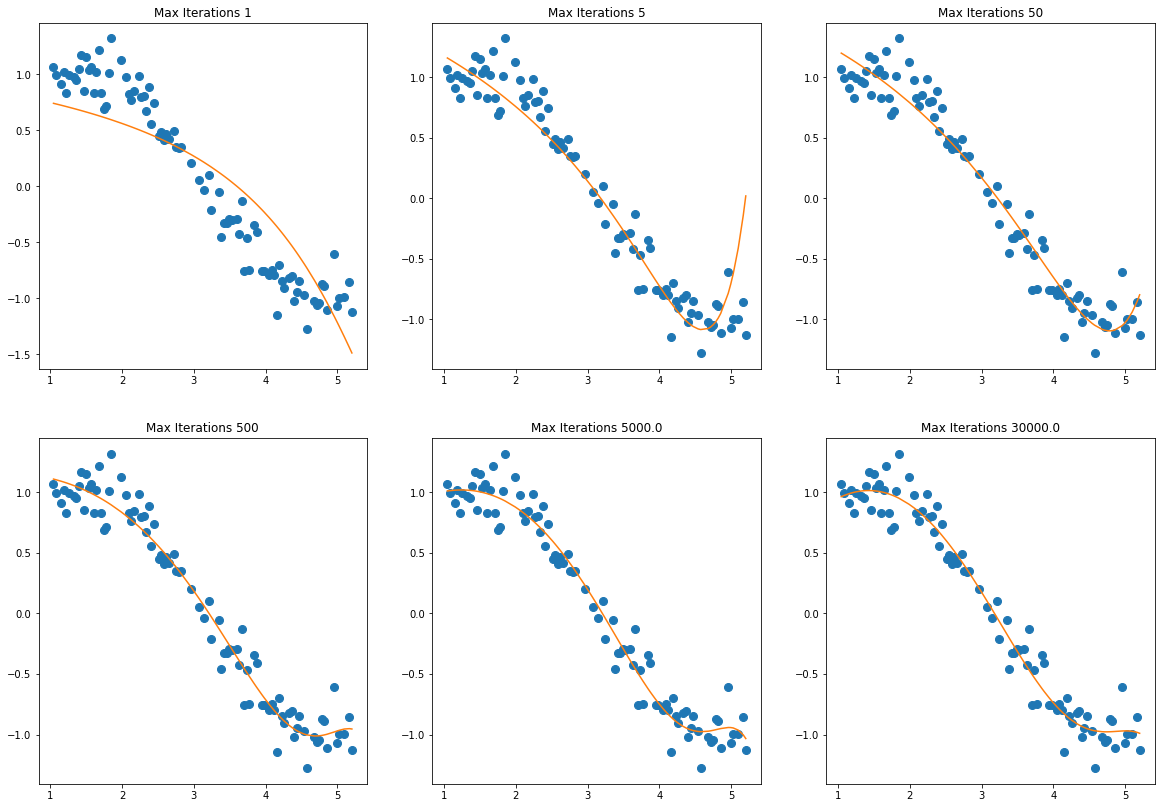

In [32]:
# ridge with stochastic gradient descent
iterations = [1,5,50,500,5e3,3e4]
plt.subplots(2,3,figsize=(20,14))

predictors=['x']
predictors.extend(['x^%d'%i for i in range(2,16)])

for i in range(6):
    plt.subplot(2,3,i+1)
    its = iterations[i]
    
    model = Ridge(alpha=0, normalize=True,max_iter=its,solver='sag',tol=1e-9)
    model.fit(data[predictors], data['y'])
    y_pred = model.predict(data[predictors])
    plt.plot(data['x'],data['y'],'.',ms=16)
    plt.plot(data['x'],y_pred)
    plt.title('Max Iterations {}'.format(its))